In [82]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime

import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# Load Statsmodels 
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## What is the problem at hand?

### `Sources`

**https://letstalkscience.ca/educational-resources/backgrounders/understanding-electricity-supply-and-demand#:~:text=Oversupply%20happens%20when%20suppliers%20generate,electricity%20can't%20be%20stored.**

**https://www.propmodo.com/how-energy-forecasting-saves-money-and-resources/#:~:text=Advancements%20in%20sensors%20and%20software,more%20efficient%2C%20and%20more%20sustainable.**

**Electrical utilities need to efficiently plan the allocation of generating units in their power plants to match their energy demand because if the demand is higher than the generation, it can cause several blackouts resulting in a huge loss to the economy. And, if the generation is higher than the demand the extra electricity will be wasted and it can also create an unnecessary load on the transmission lines.**

**Hence, it is important for the utilities to have a forecast of the energy consumption to be able to allocate appropriate resources to meet their demand. A month, week or day-ahead forecast can help the utilities plan for a larger time scale, but for smoother daily operations an hourly forecast can prove very useful. For example, if the plant operators get a high energy forecast for the next hour, they can ramp up the energy supply by switching on more power plants.**

## Potential solution?

**`Using 10 years worth of hourly energy consumption data, we could try to learn from the trends and signals and build a model to effectively forecase energy consumption for a single day. The energy comanies could utilize this model to better plan for future and in-return not only help the economy running but also reduce energy wastage.`**

## Load energy data

In [73]:
energy_df = pd.read_csv('data/power_data.csv', index_col=0)

## Explore data

In [74]:
# data types of the columns

energy_df.dtypes

Datetime      object
Power_MWH    float64
dtype: object

**There are two columns in the data - date and power consumption. Power consumption is measured in MWH**

**What is MW/MWh?** <br>
`Megawatts/Megawatt Hours: A measure of electricity equal to 1 million watts. A megawatt hour is a measure of electricity generation of 1 MW produced over one hour.`

In [75]:
# rename columns for simplicity

energy_df.rename(columns={'Datetime': 'dates', 'Power_MWH': 'power_mwh'}, inplace=True)

# conver the date col to datetime
energy_df['dates'] = pd.to_datetime(energy_df['dates'])

energy_df.dtypes

dates        datetime64[ns]
power_mwh           float64
dtype: object

In [60]:
# shape 

energy_df.shape

(75255, 2)

**There are `75255` hours of data.**

### Is there any missing data?

In [61]:
energy_df.isnull().sum()

dates        0
power_mwh    0
dtype: int64

**There is no missing data - that is great!**

In [62]:
energy_df.head()

dates  power_mwh
0 2010-01-01 00:00:00  31,647.00
1 2010-12-31 01:00:00  29,634.00
2 2010-12-31 02:00:00  28,614.00
3 2010-12-31 03:00:00  28,146.00
4 2010-12-31 04:00:00  28,051.00

In [63]:
energy_df.tail()

dates  power_mwh
75250 2018-01-01 20:00:00  44,284.00
75251 2018-01-01 21:00:00  43,751.00
75252 2018-01-01 22:00:00  42,402.00
75253 2018-01-01 23:00:00  40,164.00
75254 2018-01-02 00:00:00  38,608.00

### Descriptive statistics

In [64]:
energy_df.describe()

power_mwh
count  75,255.00
mean   31,729.89
std     6,503.00
min    14,544.00
25%    27,233.50
50%    30,838.00
75%    35,353.50
max    61,646.00

**Looks like the average power consumption based on our data is - `31,729 MWH`**

### Checking the number of rows in each year 

In [65]:
energy_df.groupby(energy_df['dates'].dt.year)['power_mwh'].count().reset_index()

dates  power_mwh
0   2010       8757
1   2011       8758
2   2012       8782
3   2013       8758
4   2014       8760
5   2015       8760
6   2016       8784
7   2017       8760
8   2018       5136

In [66]:
energy_df[energy_df.dates.dt.year==2018].head()

dates  power_mwh
61383 2018-01-01 00:00:00  39,928.00
70120 2018-08-02 01:00:00  34,283.00
70121 2018-08-02 02:00:00  32,094.00
70122 2018-08-02 03:00:00  30,543.00
70123 2018-08-02 04:00:00  29,791.00

**Looks like a few dates are missing in the data, especially in the year 2018.**

## Visualize data - EDA

In [45]:
fig = px.line(energy_df, x='dates', y=col, 
              labels={'date': 'Year-Month-Day-Hour', 'power_mwh': 'Power Consumption - MWH'},
              title="Hourly Power Consumption over the years 2010-2018")
fig.show()

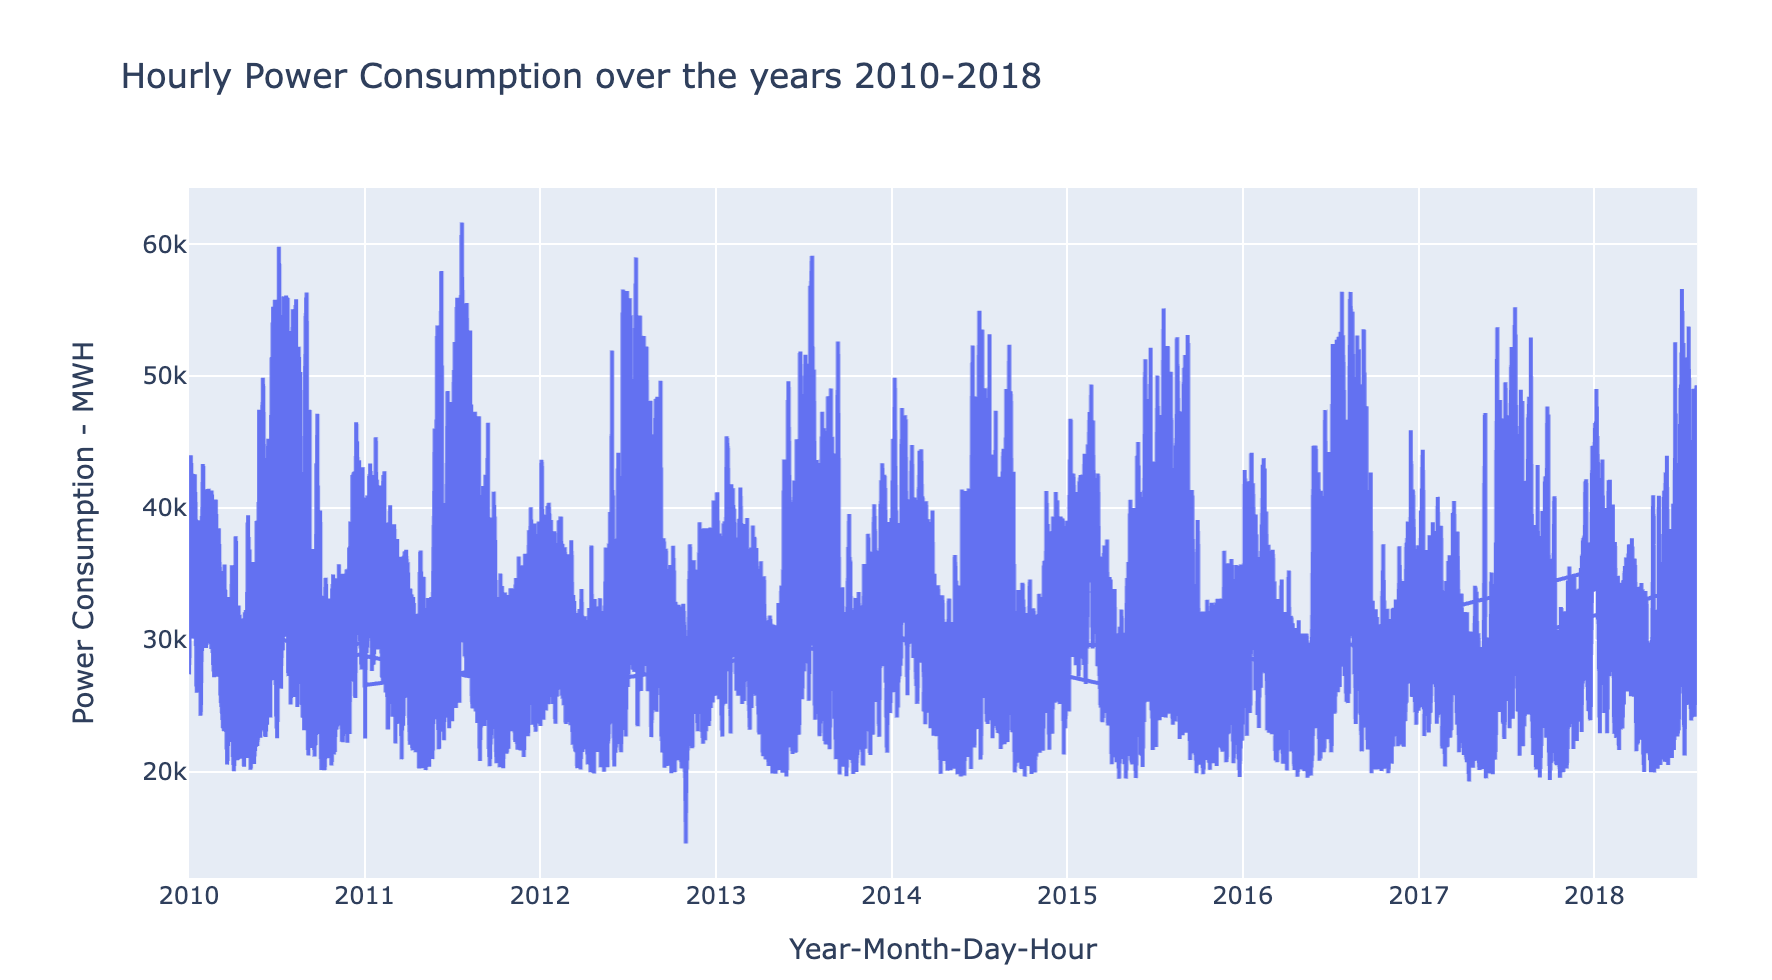

**The Power consumption data across 10 years seems non-stationary with seasonality! There doesn't seem to be a trend present but certainly seasonality. We can verify stationarity with a statistical test**

## Statistical test to check stationarity in time series 

**We will experiment with `Augmented Dickey-Fuller (ADF)`**

**Null Hypothesis (HO): Series is non-stationary.**

**Alternate Hypothesis(HA): Series is stationary.**

In [50]:
# Changing the YEAR data type and setting it as index
df = energy_df.copy()
df.index = df['dates']

del df['dates']

# ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Run test
adf_test(df['power_mwh'])


Results of Dickey-Fuller Test:
Test Statistic                   -14.16
p-value                            0.00
#Lags Used                        63.00
Number of Observations Used   75,191.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64


**The p-value is significant and hence, we can reject the null hypothesis and as expected, declare that the time series is infact stationary.**

## Feature Engineering

In [76]:
def season_calc(month):
    """ Adding season based on general understanding since we aren't aware of which city this data is from.
        months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"
      
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}

energy_df['year'] = energy_df.dates.dt.year
energy_df['month'] = energy_df.dates.dt.month
energy_df['day'] = energy_df.dates.dt.day
energy_df['hour'] = energy_df.dates.dt.hour
energy_df['weekday'] = energy_df.dates.dt.weekday.map(weekdays)
energy_df['season'] = energy_df.dates.dt.month.apply(season_calc)

# Adding holidays column to indicate whether a day was a holiday assuming this data is from US

cal = calendar()
holidays = cal.holidays(start = energy_df['dates'].min(), end = energy_df['dates'].max())
energy_df['holiday'] = energy_df['dates'].isin(holidays)

# converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday

mapped = {True:1, False:0}
energy_df.holiday = energy_df.holiday.map(mapped)
energy_df.head()

#adding in another column which indicates 'non-working' days which include weekends and holidays
energy_df['non_working'] = energy_df.apply(lambda x: 'non-working' if \
                                          ((x['holiday'] == 1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                           else 'working', axis = 1)

energy_df.head()


dates  power_mwh  year  month  day  hour weekday  season  \
0 2010-01-01 00:00:00  31,647.00  2010      1    1     0  Friday  winter   
1 2010-12-31 01:00:00  29,634.00  2010     12   31     1  Friday  winter   
2 2010-12-31 02:00:00  28,614.00  2010     12   31     2  Friday  winter   
3 2010-12-31 03:00:00  28,146.00  2010     12   31     3  Friday  winter   
4 2010-12-31 04:00:00  28,051.00  2010     12   31     4  Friday  winter   

   holiday  non_working  
0        1  non-working  
1        0      working  
2        0      working  
3        0      working  
4        0      working

### Zooming into one year at a time

In [ ]:
def zoom_

In [ ]:
df = energy_df.copy()

years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

for year in years:
    yearly_df = df[df.dates.dt.year==year]
    for col in yearly_df.columns:
        if col not in ['dates', 'year', 'day', 'hour', 'weekday' 'power_mwh']:
            fig = px.line(yearly_df, x='dates', y='power_mwh', 
                          labels={'dates': f'{col}', 'power_mwh': 'Power Consumption - MWH'},
                          title=f"{col} - Power Consumption over the year {year}",
                          color=col)
            fig.show()